# Estimadores espectrales y análisis de sistemas no ideales

## Objetivos
* Analizar cómo afecta al ruido blanco Gaussiano, que contamina la señal, la aplicación de una transformación de blanqueo.
* Estimar la potencia, velocidad Doppler y ancho de banda Doppler de los datos sobremuestreados en rango con y sin blanqueo.
* Estudiar las varianzas de los estimadores e implementar un test de toma de decisión.
* Estudiar sistemas no ideales.

## Fundamentos

Las señales de radar de meteorológico en condiciones de precipitaciones apreciables, suelen ser mucho más fuertes que el ruido. En estas condiciones, se procede al estudio de la implementación del blanqueo y sus limitaciones.

### Coloreo del ruido que contamina la señal:

Al aplicar la transformación de blanqueo a una señal contaminada por ruido blanco Gaussiano, como es el caso del simulador, el ruido se colorea dejando de ser blanco. Se define el $NEF$ (noise-enhancement factor) como: 
$$ NEF= \frac{tr\{C_v^{-1}\}}{L} $$
produciendo un ruido igual a:
$$ N_w= N(NEF) $$

donde $N$ es la potencia de ruido.

Dicho coloreo limita las utilidades de la transformación, produciendo que la reducción en la varianza de los estimadores de las muestras blanquedas tenga sentido para altos niveles de SNR. 

### Estimadores espectrales:

#### Estimador de potencia:

La estimación de potencia para las señales correlacionadas se calcula mediante: 
$$ \hat{S}_{corr} = \frac{1}{LM} \sum _{l=0}^{L-1} \sum_{m=0}^{M-1}|V(l,m)|^2 - N $$
mientras que para las señales blanqueadas: 
$$ \hat{S}_{W} = \frac{1}{LM} \sum _{l=0}^{L-1} \sum_{m=0}^{M-1}|X(l,m)|^2 - N(NEF) $$
donde $L$ es el factor de oversampling, $M$ la cantidad de pulsos y $N$ la potencia del ruido.

#### Estimador de velocidad Doppler: 

Para el estimador de velocidad se define el lag uno de la función de correlación como: 
$$ \hat{R_v}^{(T)}(1) = \frac{1}{L(M-1)}\sum _{l=0}^{L-1} \sum_{m=0}^{M-2} V^*(l,m)V(l,m+1) $$

y para la señal blanqueada de la misma manera pero con $X(l,m)$, resultando de $\hat{R_x}^{(T)}(1)$. La velocidad se estima mediante: 
$$ \hat{v}_{corr}= -\frac{\lambda}{4\pi T_s} arg \{ \hat{R_v}^{(T)}(1) \} $$
y para la señal blanqueada con $\hat{R_x}^{(T)}(1)$.

#### Estimador de ancho de banda Doppler: 
El estimador se calcula mediante: 
$$ \hat{\sigma}_{v_{corr}} = \frac{\lambda}{2\pi T_s \sqrt{2}} |ln(\frac{\hat{S}_{corr}}{|\hat{R_v}^{(T)}(1)|})|^{\frac{1}{2}} sgn [ln(\frac{\hat{S}_{corr}}{|\hat{R_v}^{(T)}(1)|})] $$ 

mientras que para la señal blanqueada de igual modo con $\hat{S}_{W}$ y $\hat{R_x}^{(T)}(1)$.





## Implementación


In [5]:
import numpy as np

# Estimadores espectrales

def estimadores(V, X, L, M, Pn, S, C_v, v_amax):
    """
    ================================INPUTS=================================== 
    V          : señal de radar meteorológico sobremuestrado en rango.
    X          : señal de radar meteorológico sobremuestrado en rango blanqueada.
    L          : factor de oversampling.
    M          : cantidad de pulsos transmitidos.
    Pn         : potencia media del ruido blanco Gaussiano aditivo.
    S          : potencia media de la señal meteorológica.
    C_v        : matriz Toepliz normalizada de correlación.
    v_amax     : velocidad amibigua.

    ==============================OUTPUTS====================================
    S_corr     : potencia estimada de la señal con correlación.
    S_w        : potencia estimada de la señal blanqueada.
    v_dop_corr : velocidad Doppler estimada de la señal con correlación.
    v_dop_W    : velocidad Doppler estimada de la señal blanqueada.
    sig_d_corr : ancho de banda Doppler estimada de la señal con correlación.
    sig_d_W    : ancho de banda Doppler estimada de la señal blanqueada.

    """

    # Expresamos las potencias en veces

    S= 10**((S-30)/10)
    Pn= 10**((Pn-30)/10)

    
    # Estimadores espectrales
    # Noise enhancement factor (NEF)

    NEF= 1/L * np.trace(np.linalg.inv(C_v))

    # Estimador de potencia de la señal con correlación

    S_corr= 0
    for i in range(L):
        for j in range(M):
            S_corr += 1/(M*L) * np.absolute(V[i,j])**2 
    S_corr= S_corr - Pn

    # Estimador de potencia de la señal blanqueada

    S_W= 0
    for i in range(L):
        for j in range(M):
            S_W += 1/(M*L) * np.absolute(X[i,j])**2 

    S_W = S_W - Pn*NEF
    
    # Estimador de autocorrelación en lag=1 señal con correlación

    Rv_1= np.zeros(1, dtype= 'complex_') 
    for j in range(L):
        for i in range(M-1):
             Rv_1 += 1/(L*(M-1)) *np.conjugate(V[j,i])*V[j,i+1]

    # Estimador de autocorrelación en lag=1 señal blanqueada

    Rx_1= np.zeros(1, dtype= 'complex_') 
    for j in range(L):
        for i in range(M-1):
             Rx_1 += 1/(L*(M-1)) *np.conjugate(X[j,i])*X[j,i+1]

    # Estimador de velocidad Doppler señal con correlación
    
    v_dop_corr = -v_amax/np.pi * np.arctan2(Rv_1.imag, Rv_1.real)

    # Estimador de velocidad Doppler señal blanqueada

    V_dop_W = -v_amax/np.pi * np.arctan2(Rx_1.imag, Rx_1.real)


    # Estimador del ancho de banda Doppler señal con correlación

    sig_d_corr= v_amax*np.sqrt(2)/np.pi * np.sqrt(np.abs(np.log(S_corr/np.abs(Rv_1)))) * np.sign(np.log(S_corr/np.abs(Rv_1)))

    # Estimador de ancho de banda Doppler señal blanqueada

    sig_d_W= v_amax*np.sqrt(2)/np.pi * np.sqrt(np.abs(np.log(S_W/np.abs(Rx_1)))) * np.sign(np.log(S_W/np.abs(Rx_1)))


    return(S_corr, S_W, v_dop_corr, V_dop_W, sig_d_corr, sig_d_W)


## Pruebas
* Se utilizan las funciones del generador de señales y el algortimo de blanqueo. Para más información leer las notas de los notebooks 'Datos sintéticos de radar meteorológico' y 'Algoritmo de blanqueo'.
* Se relevaron las curvas de desviación estándar para cada uno de los estimadores y su factor de reducción de varianza. Los datos utilizados para la simulación fueron:
  |Parámetro|Valor|
  |----|------|
  |Frecuencia de portadora|5.625 GHz|
  |Longitud de onda|5.36 cm|
  |PRI|1 ms|
  |Velocidad no ambigua|13.33 m/s|
  |Cantidad de pulsos por CPI|32|
  |Factor de oversampling|8|
  |Ancho espectral| 2 m/s|
  |Velocidad Doppler| 5 m/s|



# Relevamiento de curvas de desviaciones standar para los estimadores

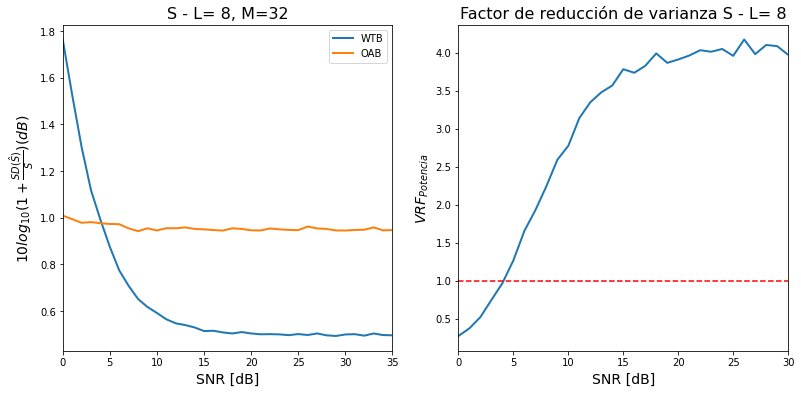

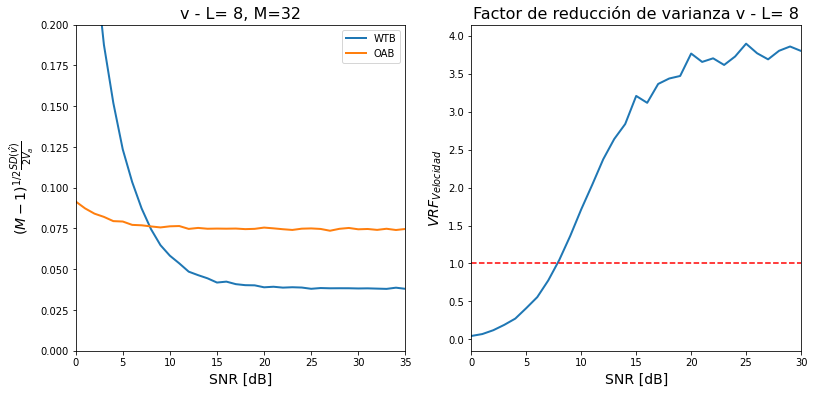

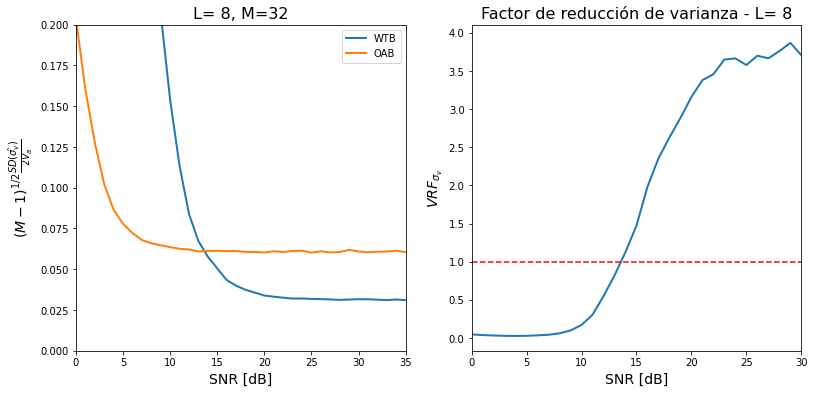

In [6]:
# RELEVAMIENTO DE CURVAS DE DESVIACIONES ESTANDAR


import numpy as np
from datos_sinteticos import datos_sinteticos
from blanqueo import blanqueo
from matplotlib import pyplot as plt 

# Generamos la señal de radar con el simulador 

L= 8  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 32 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 10 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 13.33 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
lamb= 0.0536 # Frecuencia de operanción, en m 


o= 40 # para relevar de 0 a 40 SNR
cant= 10000 # Cantidad de iteraciones para calcular las desviaciones

S_W_vector= np.zeros((o, cant),dtype = 'complex_')
S_cor_vector= np.zeros((o, cant),dtype = 'complex_')
v_dop_corr_vector= np.zeros((o, cant),dtype = 'complex_')
V_dop_W_vector= np.zeros((o, cant),dtype = 'complex_')
sig_d_corr_vector= np.zeros((o, cant),dtype = 'complex_')
sig_d_W_vector= np.zeros((o, cant),dtype = 'complex_')

for i in range(o):
    Pn= -30 + i
    for j in range(cant):
        # Datos sintetizados

        V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)
        
        # Datos blanqueados

        X, C_v= blanqueo(V, L, p_l, h_l)

        S_cor_vector[i,j], S_W_vector[i,j], v_dop_corr_vector[i,j], \
              V_dop_W_vector[i,j], sig_d_corr_vector[i,j], \
                  sig_d_W_vector[i,j]= estimadores(V, X, L, M, Pn, S, C_v, v_amax)

# Desviación standar de los estimadores de potencia para la señal blaqueada y correlacionada

Sd_S_W= np.zeros(o)
Sd_S_corr= np.zeros(o)
VRF_S=np.zeros(o)  # Factor de reducción de varianza

for i in range(o):
    Sd_S_W[i]= np.std(S_W_vector[i,:])
    Sd_S_corr[i]= np.std(S_cor_vector[i,:])
    VRF_S[i] = np.var(S_cor_vector[i,:])/ np.var(S_W_vector[i,:])
Sd_S_cor_norm=0
Sd_S_W_norm= 0
Sd_S_W_norm= Sd_S_W[::-1] / (10**((S-30)/10))
Sd_S_cor_norm= Sd_S_corr[::-1] / (10**((S-30)/10))

# Desviación standar de los estimadores de velocidad para la señal blanqueada y correlacionada

Sd_v_W= np.zeros(o)
Sd_v_corr= np.zeros(o)
VRF_v= np.zeros(o)

for i in range(o):
    Sd_v_W[i]= np.std(V_dop_W_vector[i,:])
    Sd_v_corr[i]= np.std(v_dop_corr_vector[i,:])
    VRF_v[i] = np.var(v_dop_corr_vector[i,:])/ np.var(V_dop_W_vector[i,:])

Sd_v_W_norm= Sd_v_W[::-1] /(2*v_amax)
Sd_v_cor_norm= Sd_v_corr[::-1] / (2*v_amax)

# Desviación standar de los estimadores de ancho de banda Doppler para la señal blanqueada y correlacionada

Sd_sig_W= np.zeros(o)
Sd_sig_corr= np.zeros(o)
VRF_sig= np.zeros(o)
for i in range(o):
    Sd_sig_W[i]= np.std(sig_d_W_vector[i,:])
    Sd_sig_corr[i]= np.std(sig_d_corr_vector[i,:])
    VRF_sig[i]= np.var(sig_d_corr_vector[i,:])/ np.var(sig_d_W_vector[i,:])

Sd_sig_W_norm= Sd_sig_W[::-1] /(2*v_amax)
Sd_sig_cor_norm= Sd_sig_corr[::-1] / (2*v_amax)


# Gráficas 

SNR= np.arange(0,40)


plt.figure(1, figsize=(13,6))
plt.subplot(121)
plt.plot(SNR, 10*np.log10(1+Sd_S_W_norm), label='WTB',linewidth=2)
plt.plot(SNR, 10*np.log10(1+Sd_S_cor_norm), label='OAB',linewidth=2)
plt.xlabel('SNR [dB]', fontdict= {'size': 14})
plt.xlim(0,35)
plt.ylabel(r'$10log_{10}(1+\frac{SD(\hat{S})}{S})(dB)$', fontdict= {'size': 14})
plt.title("S - L= %d, M=%d" %(L,M), fontdict= {'size': 16} )
plt.legend()

plt.subplot(122)
plt.plot(SNR, VRF_S[::-1], linewidth=2)
plt.axhline(y=1.0, color="red", linestyle="--")
plt.xlabel('SNR [dB]',fontdict= {'size': 14} )
plt.ylabel(r'$VRF_{Potencia}$', fontdict= {'size': 14})
plt.title("Factor de reducción de varianza S - L= %d" %L, fontdict= {'size': 16})
plt.xlim(0,30)

plt.figure(2, figsize=(13,6))
plt.subplot(121)
plt.plot(SNR, np.sqrt(M-1)*Sd_v_W_norm, label='WTB',linewidth=2)
plt.plot(SNR, np.sqrt(M-1)*Sd_v_cor_norm, label='OAB',linewidth=2)
plt.xlabel('SNR [dB]', fontdict= {'size': 14})
plt.ylim(0,0.2)
plt.xlim(0,35)
plt.ylabel(r'$(M-1)^{1/2}\frac{SD(\hat{v})}{2V_a}$', fontdict= {'size': 14})
plt.title("v - L= %d, M=%d" %(L,M),fontdict= {'size': 16})
plt.legend()

plt.subplot(122)
plt.plot(SNR, VRF_v[::-1],linewidth=2)
plt.axhline(y=1.0, color="red", linestyle="--")
plt.xlabel('SNR [dB]', fontdict= {'size': 14})
plt.ylabel(r'$VRF_{Velocidad}$', fontdict= {'size': 14})
plt.title("Factor de reducción de varianza v - L= %d" % L, fontdict= {'size': 16})
plt.xlim(0,30)

plt.figure(3, figsize=(13,6))
plt.subplot(121)
plt.plot(SNR, np.sqrt(M-1)*Sd_sig_W_norm, label='WTB', linewidth=2)
plt.plot(SNR, np.sqrt(M-1)*Sd_sig_cor_norm, label='OAB',linewidth=2)
plt.xlabel('SNR [dB]',fontdict= {'size': 14})
plt.ylim(0,0.2)
plt.xlim(0,35)
plt.ylabel(r'$(M-1)^{1/2}\frac{SD(\hat{\sigma_v})}{2V_a}$',fontdict= {'size': 14})
plt.title("L= %d, M=%d" %(L,M),fontdict= {'size': 16})
plt.legend()

plt.subplot(122)
plt.plot(SNR, VRF_sig[::-1],linewidth=2)
plt.axhline(y=1.0, color="red", linestyle="--")
plt.xlim(0,30)
plt.xlabel('SNR [dB]', fontdict= {'size': 14})
plt.ylabel(r'$VRF_{\sigma_v}$', fontdict= {'size': 14})
plt.title("Factor de reducción de varianza - L= %d" %L, fontdict= {'size': 16})
plt.show()




# Conclusiones
Podemos observar distintos comportamientos en los estimadores, con las gráficas de la izquierda se observan la disminución de varianza mientras que con la gráfica de la derecha podemos hallar el punto donde se intersectan las curvas. A la SNR para la cual $VRF=1$ se la denomina $SNR_c$. En base a la SNR sensada, se opta por el estimador de menor varianza de acuerdo a:
$$\hat{\theta}= \begin{cases}
\hat{\theta}_{(WTB)} & \text{si $SNR\ge SNR_c$}\\
\hat{\theta}_{(OAB)} & \text{si $SNR\le SNR_c$}
\end{cases} $$ 

* Para el estimador de potencia, si sensamos una SNR>5dB se utilizará el estimador basado en blanqueo ya que resulta de una menor varianza en su estimación. 

* Para el estimador de velocidad, se necesita de una SNR>8dB para utilizar el estimador basado en blanqueo.

* Para el estimador de ancho de banda espectral, es necesario tener una alta relación señal a ruido, SNR>14dB. Es común tener una relación señal a ruido en tormentas que puede llegar hasta SNR>25dB por lo que el método de blanqueo puede ser útil en muchas circustancias. 

* También podemos observar que debido al NEF tenemos curvas asíntoticas en las gráficas de la izquierda.

Los valores obtenidos mediante simulación son para un sistema ideal que cuenta con un receptor de ancho de banda infito y un pulso rectangular perfecto. Al apartarnos de éstas condiciones, las SNR_c serán cada vez más elevadas haciendo muchas veces inútil el método. Es por esta razón que se utilizan métodos de pseudoblanqueo para relajar condiciones en el blanqueo y obtener un menor NEF.

## Referencias

* Torres, S., 2001: ESTIMATION OF DOPPLER AND POLARIMETRIC VARIABLES FOR WEATHER RADARS. Ph.D dissertation, University of Oklahoma.
* Torres, S. and D.S.Zrinc, 2003: Whitening in Range to Improve Weather Radar Spectral Moment Estimates.
Part I: Formulation and Simulation. J. Atmos. Oceanic Technol., 20, 1433-1448.